In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sn
import pickle

from matplotlib import pyplot as plt
from io import StringIO
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, f1_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
###Data Cleanup and EDA####

In [ ]:
df_movies =  pd.read_csv('../Data/5kMovies.csv')
df_credits = pd.read_csv('../Data/5kCredits.csv')

In [53]:
df_tmdb = pd.concat([df_movies, df_credits], axis=1)

In [54]:
new_column_order = ['id', 'title', 'original_language','genres', 'release_date','runtime', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']
genres_list = ['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Thriller', 'Comedy']

In [55]:
def data_cleanup(df, new_columns):
    df_tmdb_new = df[new_column_order]
    df_tmdb_new = df_tmdb_new.loc[:, ~df_tmdb_new.columns.duplicated()]
    
    categorical= list(df_tmdb_new.dtypes[df_tmdb_new.dtypes=='object'].index)
    numerical = list(df_tmdb_new.dtypes[df_tmdb_new.dtypes!='object'].index)
    
    for c in categorical:
        df_tmdb_new = df = df_tmdb_new[df_tmdb_new[c].notna()]
        #df_tmdb_new.loc[:,c] = df_tmdb_new.loc[:,c].fillna('NA')

    for c in numerical:
        df_tmdb_new.loc[:,c] = df_tmdb_new.loc[:,c].fillna(0)
    
    df_filtered = df_tmdb_new[df_tmdb_new['genres'].str.len() > 2]

    df_filtered = df_filtered[df_filtered['release_date'].str.len() > 2]
    df_filtered['release_date_dt'] = pd.to_datetime(df_filtered['release_date'])
    df_filtered['release_year'] = df_filtered['release_date_dt'].dt.year
    df_filtered = df_filtered.drop('release_date', axis=1)
    df_filtered = df_filtered.drop('release_date_dt', axis=1)

    df_filtered.columns = ['id', 'title', 'language','genres','runtime', 'popularity', 'vote_count', 'vote_avg', 'budget', 'revenue', 'release_year']
    
    return df_filtered

In [56]:
def jsontocsv(jsonstr:list):
    df = pd.read_json(StringIO(jsonstr))
    csv_string = ', '.join(df['name'].apply(str))
    return csv_string

In [57]:
def genres_json_to_csv(row):
    return jsontocsv(row['genres'])

In [58]:
def normalize_genres(df_movies):
    df_movies['genres_csv'] = df_movies.apply(genres_json_to_csv, axis=1)
    for g in genres_list:
        df_movies[g] = df_movies['genres_csv'].apply(lambda x: g in x)
    df_movies = df_movies.drop('genres_csv', axis=1)
    df_movies = df_movies.drop('genres', axis=1)
    return df_movies

In [59]:
df_movies = data_cleanup(df_tmdb, new_column_order)
df_movies = normalize_genres(df_movies)

In [60]:
df_movies.columns = df_movies.columns.str.lower()
df_movies.columns = df_movies.columns.str.replace(' ','_')
df_movies.head(3)

,id,title,language,runtime,popularity,vote_count,vote_avg,budget,revenue,release_year,action,adventure,fantasy,science_fiction,thriller,comedy
0,19995,Avatar,en,162.0,150.437577,11800,7.2,237000000,2787965087,2009,True,True,True,True,False,False
1,285,Pirates of the Caribbean: At World's End,en,169.0,139.082615,4500,6.9,300000000,961000000,2007,True,True,True,False,False,False
2,206647,Spectre,en,148.0,107.376788,4466,6.3,245000000,880674609,2015,True,True,False,False,False,False


In [13]:
####### Data Preparation for Regression. Run LinearRegression #######
####### Run RandomForestRegression. Tune to arrive at best parameters  #######
####### Compare Linear regression and  RandomForestRegression with best parameters. Finalize the better model as model #######

In [14]:
####### Data Preparation for Regression. #######

In [15]:
features = ['id', 'title', 'runtime', 'popularity', 'vote_avg', 'budget']
df_movies = df_movies[(df_movies['budget'] > 0) & (df_movies['revenue'] > 0)].dropna(subset=features)

df_movies['log_budget'] = np.log1p(df_movies['budget'])
df_movies['log_revenue'] = np.log1p(df_movies['revenue'])

interested_features = ['runtime', 'popularity', 'vote_avg','log_budget']
target = 'log_revenue'

In [16]:
X_full = df_movies[interested_features]
y_full = df_movies[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
len(X_train), len(X_val), len(X_test)

(1936, 646, 646)

In [17]:
####### Run LinearRegression #######

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
y_pred_linear_val = lin_reg.predict(X_val)

In [20]:
r2s_lin_reg = r2_score(y_val, y_pred_linear_val)
rmse_lin_reg = mean_squared_error(y_val, y_pred_linear_val) 

print("R^2 Score", r2s_lin_reg)
print("RMSE", rmse_lin_reg)

np.set_printoptions(suppress=True, precision=6)
coefficients = pd.DataFrame({'feature':interested_features, 'coefficient' : lin_reg.coef_})
print(coefficients.round(6))

R^2 Score 0.6199316012534258
RMSE 1.7602471082978466
      feature  coefficient
0     runtime    -0.005564
1  popularity     0.010782
2    vote_avg     0.409942
3  log_budget     0.814482


In [21]:
####### RandomForest Regression #######

In [22]:
rf_regression= RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=-1)
rf_regression.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
y_pred_rf_val = rf_regression.predict(X_val)

In [24]:
print("R^2 Score", r2_score(y_val, y_pred_rf_val))
print("RMSE", mean_squared_error(y_val, y_pred_rf_val))

R^2 Score 0.5602266793541637
RMSE 2.036764220667406


In [25]:
interested_features

importances = rf_regression.feature_importances_
most_important_index = np.argmax(importances)
most_important_index
most_important_feature = interested_features[most_important_index]
print(most_important_feature)

feat_imp = pd.Series(importances, index=X_full.columns).sort_values(ascending=False)
print(feat_imp)

popularity
popularity    0.438044
log_budget    0.379688
runtime       0.096593
vote_avg      0.085675
dtype: float64


In [26]:
def random_forest_varied_depth_estimator(depth, estimator):
    rf= RandomForestRegressor(n_estimators=estimator,max_depth=depth, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2s = r2_score(y_val, y_pred)
    return rmse, r2s

In [27]:
def find_best_depth_estimator():
    depths = [10,15,20,25, 30, 35]
    estimators = np.arange(10,210,10)

    rmse_summary = {}
    r2s_summary = {}
    results_list = []
    
    for depth in depths:
        rmses=[]
        r2ses=[]
        for estimator in estimators:
            rmse, r2s = random_forest_varied_depth_estimator(depth, estimator)
            rmses.append(rmse)
            r2ses.append(r2s)
            results_list.append({
                'depth' : depth,
                'estimator' : estimator,
                'rmse': rmse,
                'r2s' : r2s
            })
            
        rmse_summary[depth] = np.mean(rmses)
        r2s_summary[depth] = np.mean(r2ses)

    best_depth= min(rmse_summary, key=rmse_summary.get)
    
    results_df=pd.DataFrame(results_list)
    best_results_from_max_depth = results_df[results_df['depth']==best_depth]
    
    best_result_row = best_results_from_max_depth.loc[best_results_from_max_depth['rmse'].idxmin()]
    best_estimator = int(best_result_row['estimator'])
    return best_depth, best_estimator

In [28]:
best_max_depth, best_estimator = find_best_depth_estimator()
print("MAX Depth : ",best_max_depth)
print("Estimator : ",best_estimator)

best_rf_regressor = RandomForestRegressor(n_estimators=best_estimator,random_state=42, n_jobs=-1, max_depth=best_max_depth)
best_rf_regressor.fit(X_train, y_train)

y_pred_best_rf_val = rf_regression.predict(X_val)

MAX Depth :  10
Estimator :  100


In [29]:
print(best_max_depth, best_estimator)
r2s_rf_reg  = r2_score(y_val, y_pred_best_rf_val)
rmse_rf_reg = mean_squared_error(y_val, y_pred_best_rf_val)

print("R2 Square of Random Forest : ", r2s_rf_reg)
print("RMSE of Random Forest : ", rmse_rf_reg)

10 100
R2 Square of Random Forest :  0.5602266793541637
RMSE of Random Forest :  2.036764220667406


In [30]:
#######  Choose between the Linear and RF Model now ##########

In [31]:
if(rmse_rf_reg < rmse_lin_reg):
    print("Random Forest is better")
else:
    print("Linear Regression is better")

Linear Regression is better


In [32]:
####### Now Check for GradientBoostingRegressor Regression and hypertuning parameters #######


Gradient Boosting Results:
RMSE: $1.23M
R² Score: 0.6732
MAE: $0.83M

 Feature Importance:
      feature  importance
1  popularity    0.516032
3  log_budget    0.424074
0     runtime    0.033891
2    vote_avg    0.026002


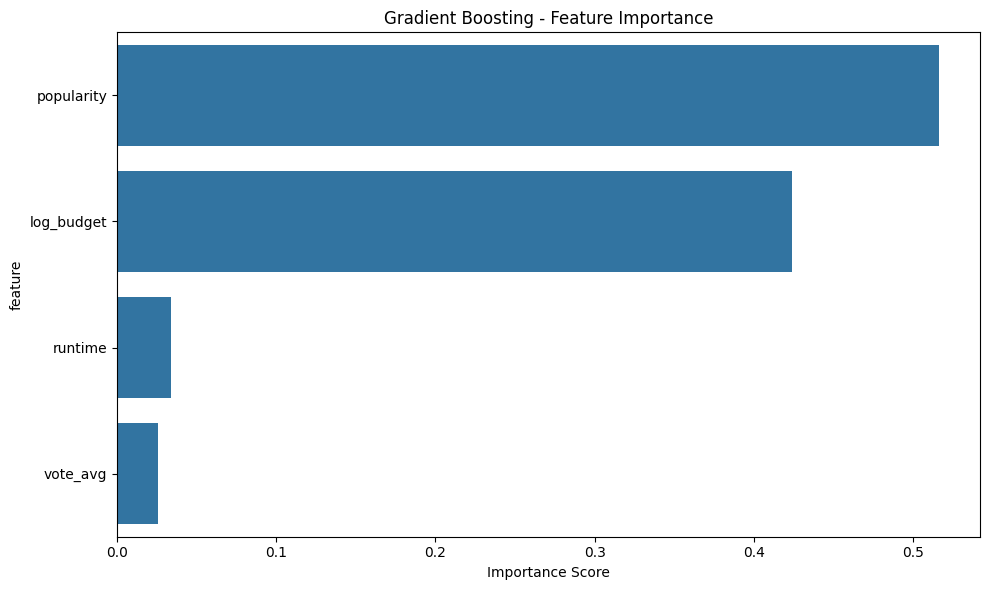

In [ ]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # How much each tree contributes
    max_depth=3,           # Maximum depth of each tree
    min_samples_split=2,   # Minimum samples required to split
    min_samples_leaf=1,    # Minimum samples required at leaf node
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_val_gb = gb_model.predict(X_val)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_gb))
r2 = r2_score(y_val, y_pred_val_gb)
mae = mean_absolute_error(y_val, y_pred_val_gb)

print("\nGradient Boosting Results:")
print(f"RMSE: ${rmse:.2f}M")
print(f"R² Score: {r2:.4f}")
print(f"MAE: ${mae:.2f}M")


feature_importance = pd.DataFrame({
    'feature': X_full.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sn.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Gradient Boosting - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

In [34]:
print("Model Type:", type(gb_model))
print("Model Parameters:", gb_model.get_params())

Model Type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Model Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [35]:
####### Check for XGBoost and hypertuning parameters #######

In [36]:
import xgboost as xgb

In [37]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Step size shrinkage
    max_depth=3,                   # Maximum tree depth
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_compare_xgb_vals = xgb_model.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred_compare_xgb_vals))
r2 = r2_score(y_val, y_pred_compare_xgb_vals)
mae = mean_absolute_error(y_val, y_pred_compare_xgb_vals)

print("XGBoost Results:")
print(f"RMSE: ${rmse:.2f}M")
print(f"R² Score: {r2:.4f}")
print(f"MAE: ${mae:.2f}M")

XGBoost Results:
RMSE: $1.26M
R² Score: 0.6552
MAE: $0.85M


In [38]:
model_params = xgb_model.get_xgb_params()
print(model_params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [39]:
#####Storing All Models ######

In [40]:
## Storing the Linear Regression Model

with open('_models/movie_revenue_linreg_model.bin', 'wb') as f:
    pickle.dump(lin_reg, f)

## Storing the RandomForest Regression Model

with open('_models/movie_revenue_rf_model.bin', 'wb') as f:
    pickle.dump(rf_regression, f)

## Storing the Gradient Boost Regression Model
with open('_models/movie_revenue_gb_model.bin', 'wb') as f:
    pickle.dump(gb_model, f)

## Storing the XGB Regression Model
with open('_models/movie_revenue_xgb_model.bin', 'wb') as f:
    pickle.dump(xgb_model, f)

In [41]:
### Comparing all the models with hyper tune parameters and plotting graphs ########

Name of Model Linear Regression
Name of Model LinearRegression()


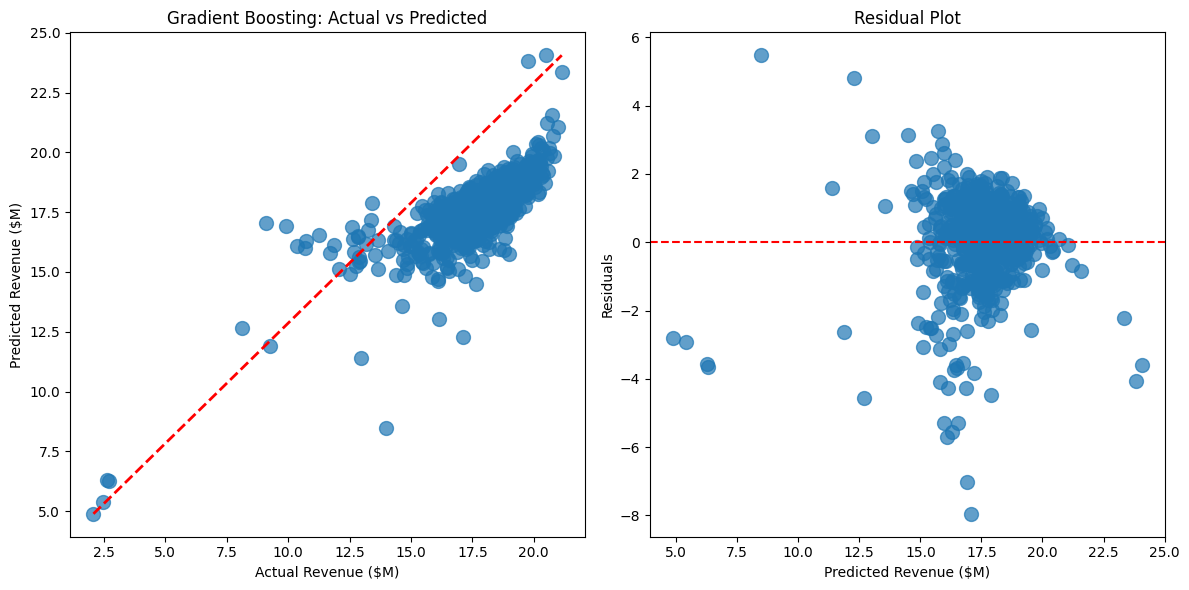

Name of Model Random Forest
Name of Model RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)


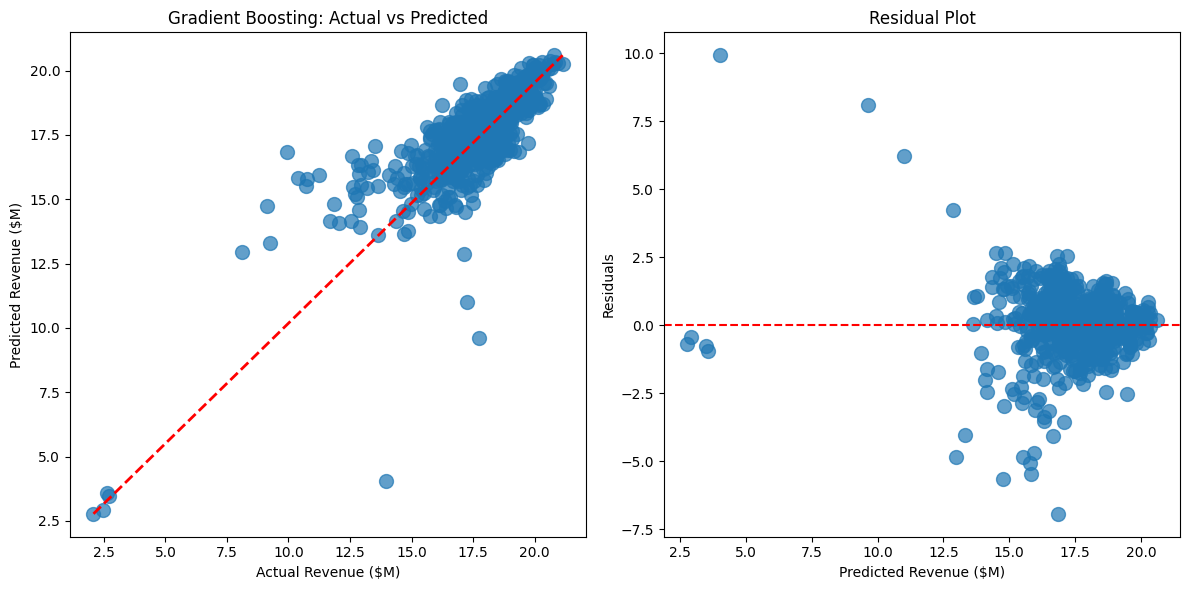

Name of Model Gradient Boosting
Name of Model GradientBoostingRegressor(random_state=42)


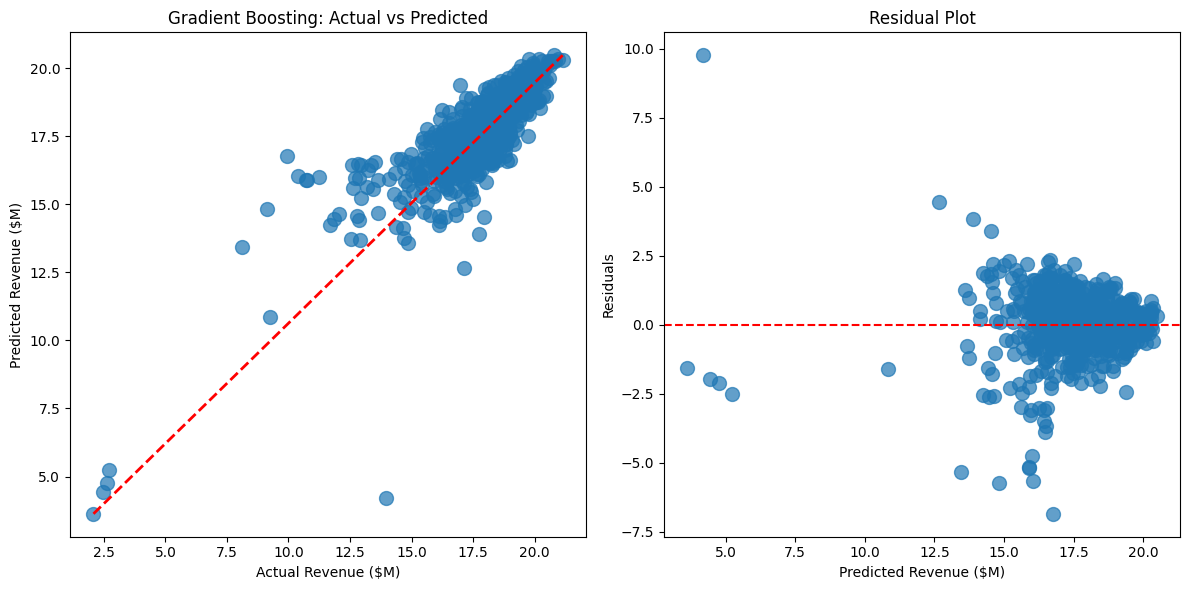

Name of Model XGB Regression
Name of Model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)


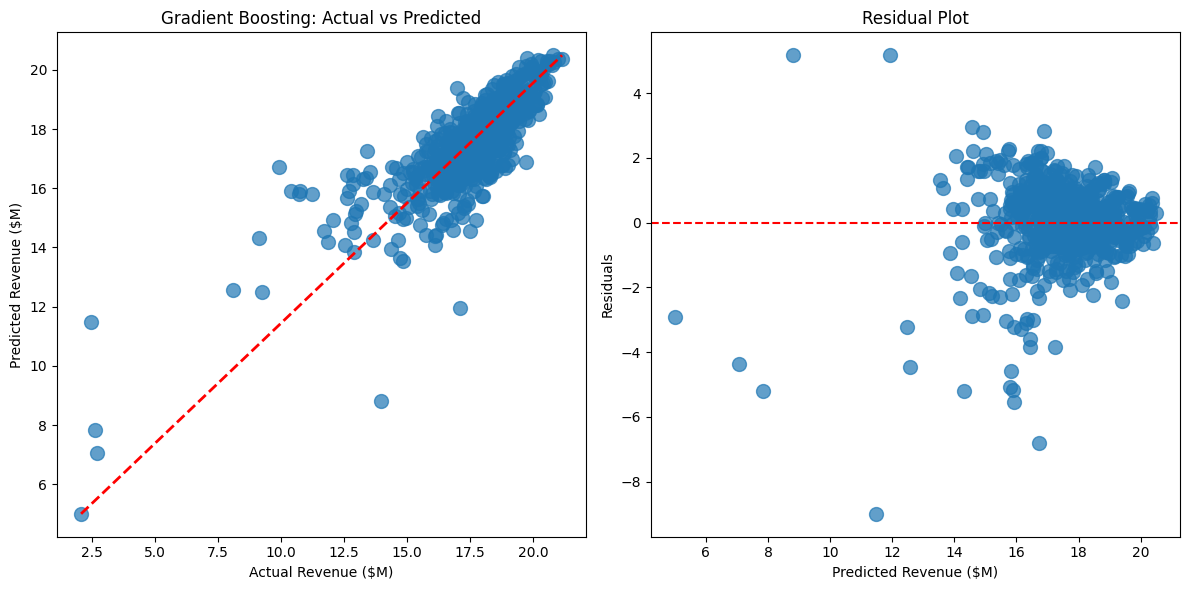


Model Comparison:
                     RMSE      R²     MAE
Linear Regression  1.3267  0.6199  0.9125
Random Forest      1.2949  0.6379  0.8572
Gradient Boosting  1.2302  0.6732  0.8282
XGB Regression     1.2637  0.6552  0.8519


In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100,random_state=42, n_jobs=-1, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42,loss='squared_error'),
    'XGB Regression' : xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.1,max_depth=3,random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_compare_vals = model.predict(X_val)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_compare_vals)),
        'R²': r2_score(y_val, y_pred_compare_vals),
        'MAE': mean_absolute_error(y_val, y_pred_compare_vals)
    }

    plt.figure(figsize=(12, 6))

    print("Name of Model", name)
    # Plot 1: Predictions vs Actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_val, y_pred_compare_vals, alpha=0.7, s=100)
    plt.plot([y_val.min(), y_val.max()], [y_pred_compare_vals.min(), y_pred_compare_vals.max()], 'r--', lw=2)
    plt.xlabel('Actual Revenue ($M)')
    plt.ylabel('Predicted Revenue ($M)')
    plt.title('Gradient Boosting: Actual vs Predicted')
    
    # Plot 2: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_val - y_pred_compare_vals
    plt.scatter(y_pred_compare_vals, residuals, alpha=0.7, s=100)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Revenue ($M)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

# Compare results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(4))

In [ ]:
####Now lets choose the final model from above comparison #####

In [49]:
chosen_model = gb_model

with open('_models/regression_model.bin', 'wb') as f:
    pickle.dump(chosen_model, f)

In [50]:
y_pred_final = chosen_model.predict(X_val[:5])
print("runtime", "popularity", "vote_avg", "log_budget")
output = zip(X_val[:5]['runtime'], X_val[:5]['popularity'],X_val[:5]['vote_avg'],X_val[:5]['log_budget'], y_val[:5], y_pred_final)
for item in list(output):
    print("runtime", item[0])
    print("popularity",item[1])
    print("Vote_average", item[2])
    print("log_budget", item[3])
    print("log_revenue", item[4])
    print("Budget", np.expm1(item[3])/np.power(10,6))
    print("Actual Revenue", np.expm1(item[4])/np.power(10,6))
    print("Predict Revenue", np.expm1(item[5])/np.power(10,6))
    print("\n\n")

runtime popularity vote_avg log_budget
runtime 102.0
popularity 14.793177
Vote_average 7.5
log_budget 15.894952224644102
log_revenue 18.425898925530607
Budget 8.000000000000002
Actual Revenue 100.5231810000001
Predict Revenue 18.311359378651506



runtime 118.0
popularity 28.670477
Vote_average 5.7
log_budget 17.370858648025116
log_revenue 17.648850507639814
Budget 35.000000000000014
Actual Revenue 46.216641
Predict Revenue 75.05388678294418



runtime 112.0
popularity 9.969624
Vote_average 6.3
log_budget 16.380459992348886
log_revenue 18.326790602416278
Budget 13.000000000000012
Actual Revenue 91.03827600000014
Predict Revenue 14.950906079097514



runtime 110.0
popularity 46.078371
Vote_average 5.9
log_budget 17.453096744006448
log_revenue 18.53707182462208
Budget 37.999999999999964
Actual Revenue 112.34351300000004
Predict Revenue 137.8107827680833



runtime 127.0
popularity 21.685719
Vote_average 6.7
log_budget 17.909855136853043
log_revenue 18.29039203101183
Budget 60.00000000000

In [51]:
new_data = [
  {
    "runtime": 102.0,
    "popularity": 14.793177,
    "vote_avg": 7.5,
    "log_budget": 15.894952
  },
  {
    "runtime": 118.0,
    "popularity": 28.670477,
    "vote_avg": 5.7,
    "log_budget": 17.370859
  },
  {
    "runtime": 112.0,
    "popularity": 9.969624,
    "vote_avg": 6.3,
    "log_budget": 16.38046
  },
  {
    "runtime": 110.0,
    "popularity": 46.078371,
    "vote_avg": 5.9,
    "log_budget": 17.453097
  },
  {
    "runtime": 127.0,
    "popularity": 21.685719,
    "vote_avg": 6.7,
    "log_budget": 17.909855
  }
]

df_new_data = pd.DataFrame(new_data)

for index,row in df_new_data.iterrows():
    print("runtime", row['runtime'])
    print("popularity", row['popularity'])
    print("Vote_average", row['vote_avg'])
    print("log_budget", row['log_budget'])
    budget=np.expm1(row['log_budget'])/np.power(10,6)
    print(f"budget: ${budget:.2f}M")
    predicted_revenue = chosen_model.predict(df_new_data)[index]
    revenue=np.expm1(predicted_revenue)/np.power(10,6)
    print(f"Revenue: ${revenue:.2f}M")
    print("\n\n")


runtime 102.0
popularity 14.793177
Vote_average 7.5
log_budget 15.894952
budget: $8.00M
Revenue: $18.31M



runtime 118.0
popularity 28.670477
Vote_average 5.7
log_budget 17.370859
budget: $35.00M
Revenue: $75.05M



runtime 112.0
popularity 9.969624
Vote_average 6.3
log_budget 16.38046
budget: $13.00M
Revenue: $14.95M



runtime 110.0
popularity 46.078371
Vote_average 5.9
log_budget 17.453097
budget: $38.00M
Revenue: $137.81M



runtime 127.0
popularity 21.685719
Vote_average 6.7
log_budget 17.909855
budget: $60.00M
Revenue: $91.69M



